# Energy Consumption Forecasting: EDA Notebook
This notebook follows a modular workflow for time series forecasting, from data understanding to model saving.

consumption    int64
dtype: object

Columns: ['consumption']
Missing values per column:


consumption    0
dtype: int64

Duplicate rows: 26
Datetime index frequency: MS
Datetime index is regular: True


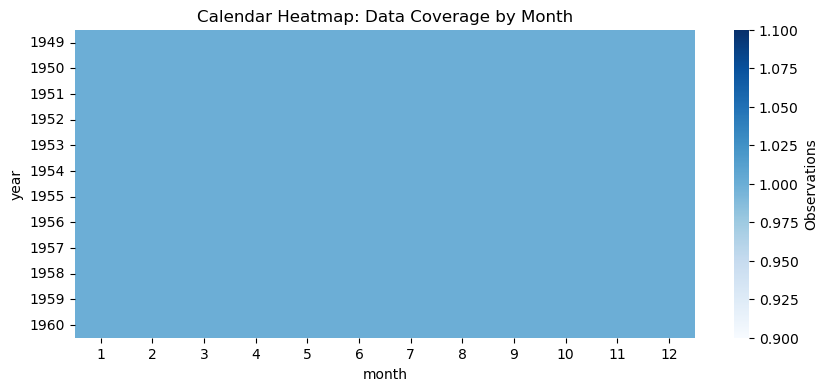

In [26]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# STEP 1: Data Understanding & Profiling
# Ensure datetime is the index
if 'datetime' in df.columns:
    df = df.set_index('datetime')

# Print column names and dtypes
display(df.dtypes)
print('Columns:', df.columns.tolist())

# Check for missing and duplicate values
print('Missing values per column:')
display(df.isnull().sum())
print('Duplicate rows:', df.duplicated().sum())

# Check datetime index frequency and regularity
if not df.index.is_monotonic_increasing:
    df = df.sort_index()
if isinstance(df.index, pd.DatetimeIndex):
    print('Datetime index frequency:', pd.infer_freq(df.index))
    print('Datetime index is regular:', pd.infer_freq(df.index) is not None)
else:
    print('Index is not a DatetimeIndex.')

# Calendar heatmap for time coverage (monthly)
if isinstance(df.index, pd.DatetimeIndex) and hasattr(df.index, 'month'):
    df['year'] = df.index.year
    df['month'] = df.index.month
    pivot = df.pivot_table(index='year', columns='month', values='consumption', aggfunc='count')
    plt.figure(figsize=(10,4))
    sns.heatmap(pivot, cmap='Blues', cbar_kws={'label': 'Observations'})
    plt.title('Calendar Heatmap: Data Coverage by Month')
    plt.show()
    df.drop(['year','month'], axis=1, inplace=True)

In [27]:
# Load a sample time series dataset (Air Passengers) using seaborn
import seaborn as sns
import pandas as pd
df = sns.load_dataset('flights')
df['datetime'] = pd.to_datetime(df[['year', 'month']].astype(str).agg('-'.join, axis=1))
df = df.rename(columns={'passengers': 'consumption'})
df = df[['datetime', 'consumption']]
df.head()

C:\Users\HAMZA\AppData\Local\Temp\ipykernel_6424\259455594.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df[['year', 'month']].astype(str).agg('-'.join, axis=1))


,datetime,consumption
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     144 non-null    datetime64[ns]
 1   consumption  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


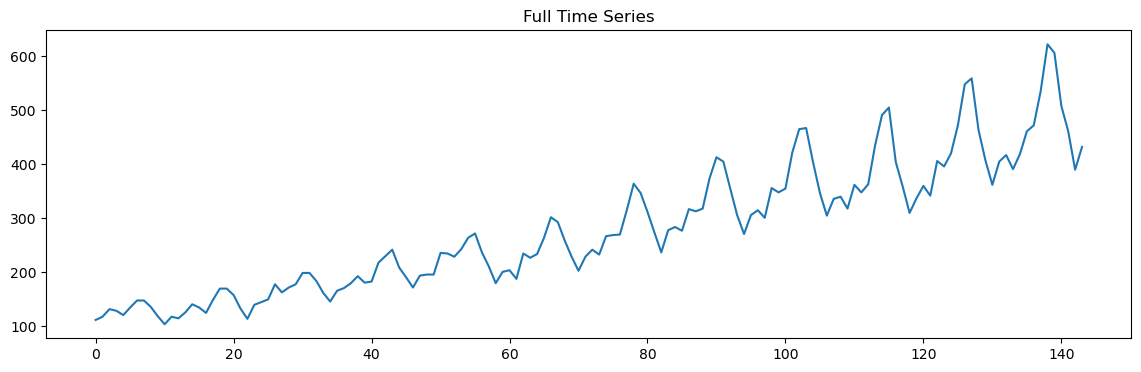

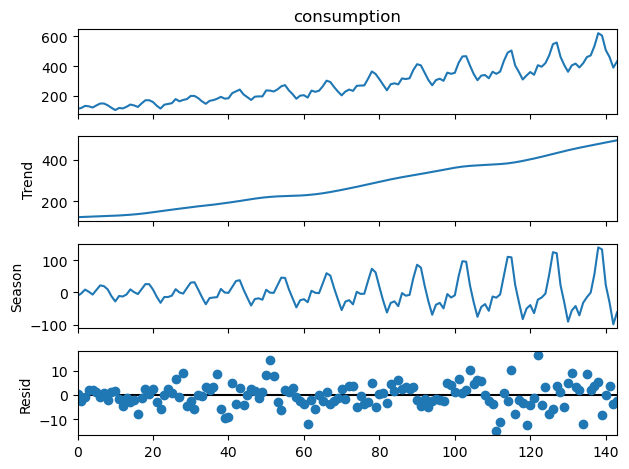

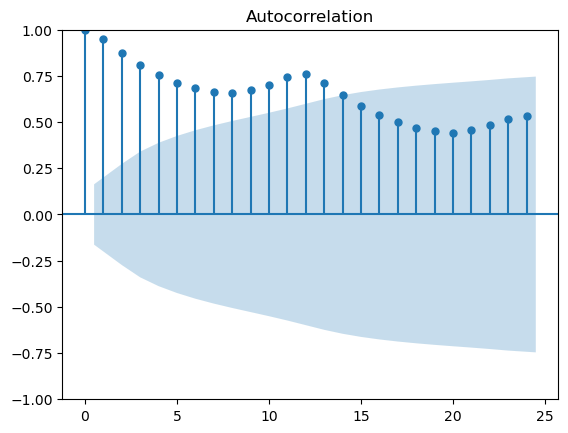

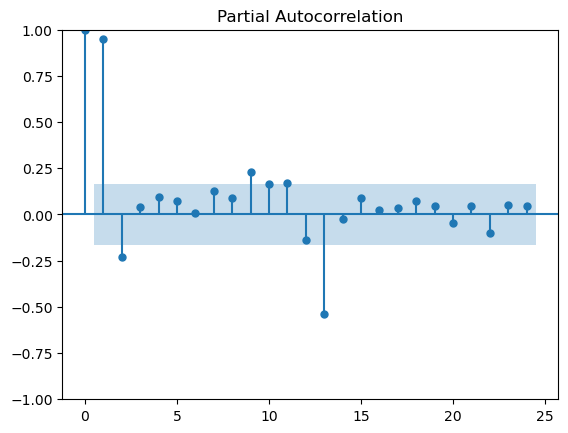

KPSS Statistic: 1.651, p-value: 0.010


C:\Users\HAMZA\AppData\Local\Temp\ipykernel_6424\2493398319.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(df['consumption'].dropna(), regression='c', nlags='auto')


ValueError: Unknown format code 'f' for object of type 'str'

In [28]:
# Data info and summary
df.info()
df.describe()

# STEP 2: Exploratory Time Series Analysis
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

# Line plot (full series)
plt.figure(figsize=(14,4))
plt.plot(df.index, df['consumption'])
plt.title('Full Time Series')
plt.show()

# STL decomposition
from statsmodels.tsa.seasonal import STL
stl = STL(df['consumption'], period=12)
res = stl.fit()
res.plot()
plt.show()

# ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['consumption'].dropna(), lags=24)
plt.show()
plot_pacf(df['consumption'].dropna(), lags=24)
plt.show()

# KPSS test
kpss_stat, kpss_p, _, _ = kpss(df['consumption'].dropna(), regression='c', nlags='auto')
print(f'KPSS Statistic: {kpss_stat:.3f}, p-value: {kpss_p:.3f}')

# Ljung-Box test
lb_stat, lb_p = acorr_ljungbox(df['consumption'].dropna(), lags=[12], return_df=False)
print(f'Ljung-Box p-value (lag 12): {lb_p[0]:.3f}')

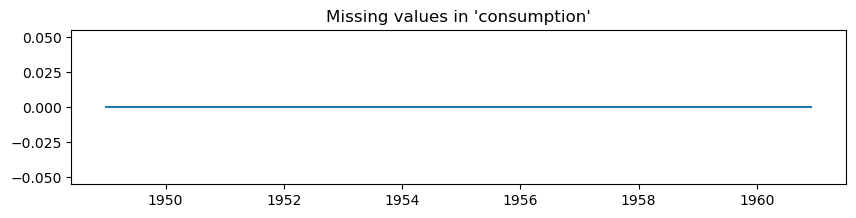

C:\Users\HAMZA\AppData\Local\Temp\ipykernel_6424\4006348102.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['consumption'] = df['consumption'].fillna(method='ffill')


,consumption,year,month,day,weekday,consumption_lag1,consumption_rolling3
datetime,,,,,,,
1949-01-01,112,1949,1,1,5,NaN,NaN
1949-02-01,118,1949,2,1,1,112.0,NaN
1949-03-01,132,1949,3,1,1,118.0,120.666667
1949-04-01,129,1949,4,1,4,132.0,126.333333
1949-05-01,121,1949,5,1,6,129.0,127.333333


In [ ]:
# Ensure datetime is the index and sorted
df = df.sort_values('datetime').set_index('datetime')

# Visualize missing values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 2))
plt.title("Missing values in 'consumption'")
plt.plot(df['consumption'].isna())
plt.show()

# Fill missing values (if any) with forward fill
df['consumption'] = df['consumption'].fillna(method='ffill')

# Feature engineering: extract time features
# Time-based features
if not 'year' in df.columns:
    df['year'] = df.index.year
if not 'month' in df.columns:
    df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday

# Lag features
df['consumption_lag1'] = df['consumption'].shift(1)

# Rolling features
df['consumption_rolling3'] = df['consumption'].rolling(window=3).mean()
df['consumption_rolling12'] = df['consumption'].rolling(window=12).mean()

df.head()

duplicate_timestamps: 0
constant_columns: []
monotonic_increasing: True
monotonic_decreasing: False
outlier_count: 0
adf_statistic: 0.8153688792060547
adf_pvalue: 0.9918802434376411


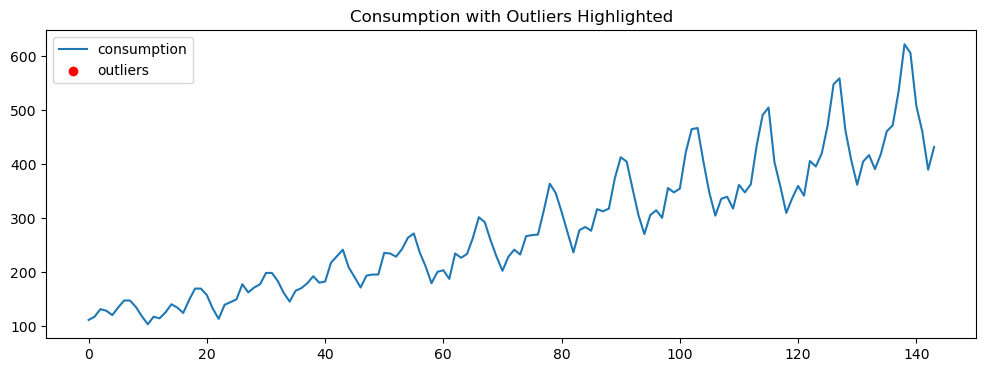

In [29]:
# Global time series data checks for robust preprocessing
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
summary = {}
## 1. Check for duplicate timestamps
summary['duplicate_timestamps'] = df.index.duplicated().sum()
## 2. Check for constant columns
summary['constant_columns'] = [col for col in df.columns if df[col].nunique() == 1]
## 3. Check for monotonicity
summary['monotonic_increasing'] = df.index.is_monotonic_increasing
summary['monotonic_decreasing'] = df.index.is_monotonic_decreasing
## 4. Outlier detection (IQR method)
Q1 = df['consumption'].quantile(0.25)
Q3 = df['consumption'].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (df['consumption'] < (Q1 - 1.5 * IQR)) | (df['consumption'] > (Q3 + 1.5 * IQR))
summary['outlier_count'] = outlier_mask.sum()
## 5. Stationarity test (ADF)
adf_result = adfuller(df['consumption'].dropna())
summary['adf_statistic'] = adf_result[0]
summary['adf_pvalue'] = adf_result[1]
## 6. Print summary
for k, v in summary.items():
    print(f'{k}: {v}')
## 7. Visualize outliers
plt.figure(figsize=(12,4))
plt.plot(df.index, df['consumption'], label='consumption')
plt.scatter(df.index[outlier_mask], df['consumption'][outlier_mask], color='red', label='outliers')
plt.legend()
plt.title('Consumption with Outliers Highlighted')
plt.show()

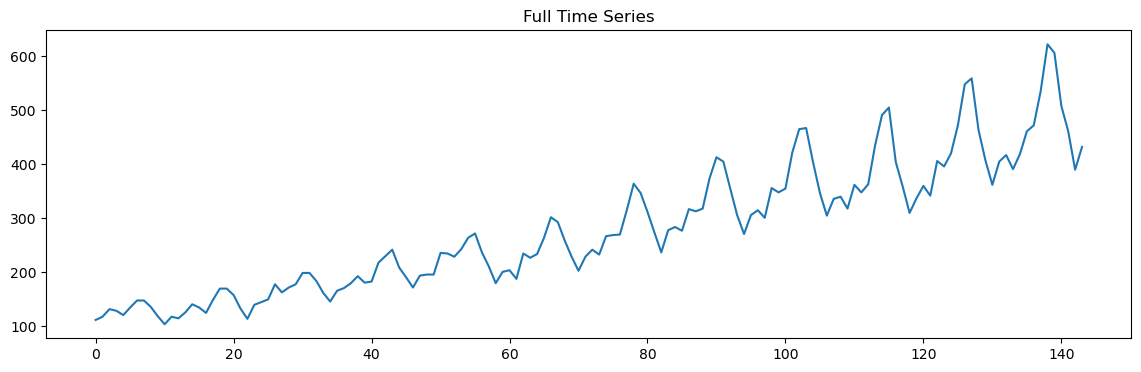

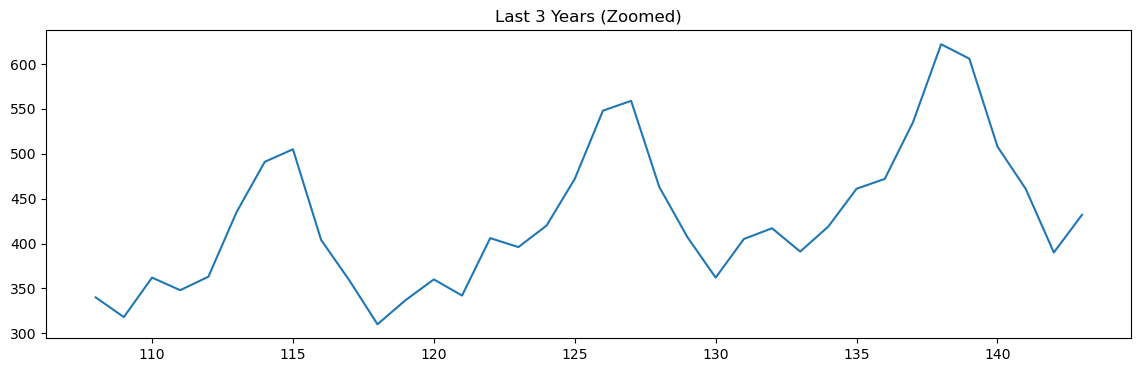

In [30]:
# 1. Time series plot (full and zoomed)
plt.figure(figsize=(14,4))
plt.plot(df.index, df['consumption'])
plt.title('Full Time Series')
plt.show()

plt.figure(figsize=(14,4))
plt.plot(df.index[-36:], df['consumption'][-36:])
plt.title('Last 3 Years (Zoomed)')
plt.show()

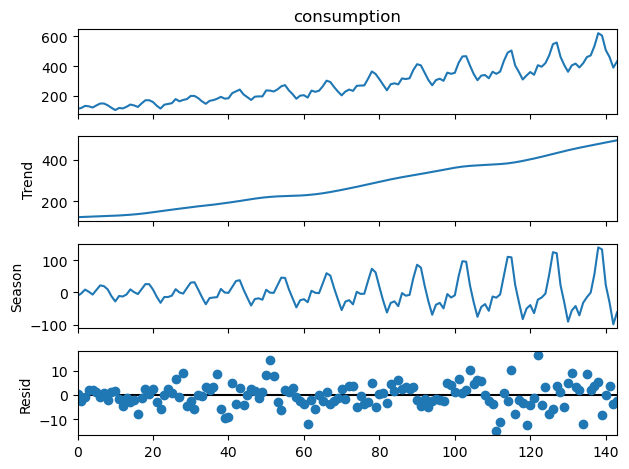

In [31]:
# 2. STL Decomposition
from statsmodels.tsa.seasonal import STL
stl = STL(df['consumption'], period=12)
res = stl.fit()
res.plot()
plt.show()

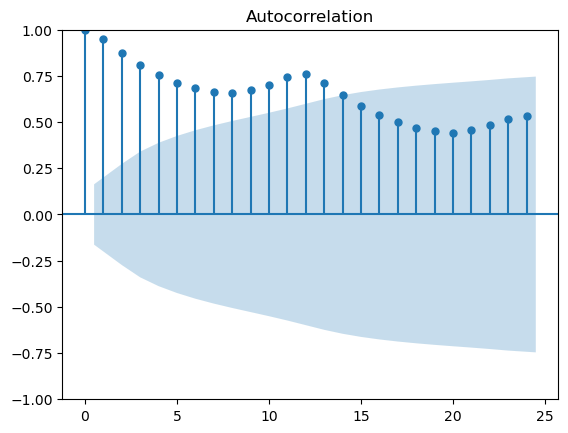

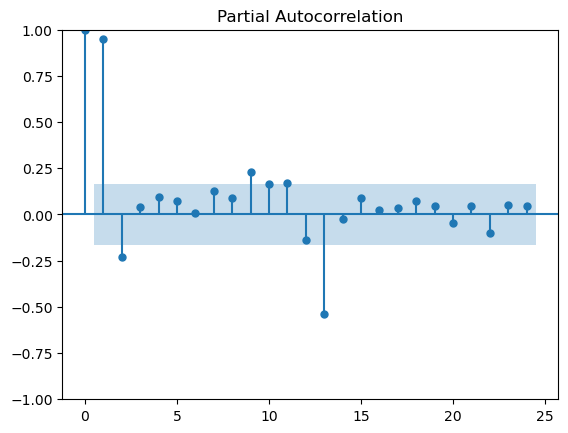

In [32]:
# 3. ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['consumption'].dropna(), lags=24)
plt.show()
plot_pacf(df['consumption'].dropna(), lags=24)
plt.show()

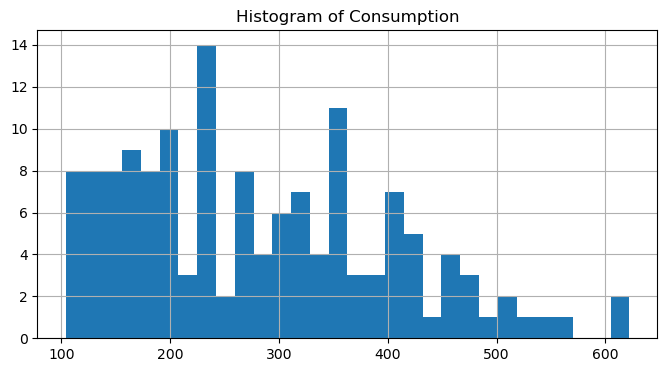

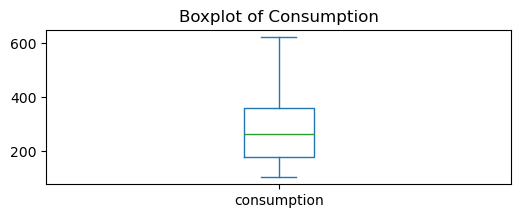

In [33]:
# 4. Distribution plots
plt.figure(figsize=(8,4))
df['consumption'].hist(bins=30)
plt.title('Histogram of Consumption')
plt.show()

plt.figure(figsize=(6,2))
df['consumption'].plot.box()
plt.title('Boxplot of Consumption')
plt.show()

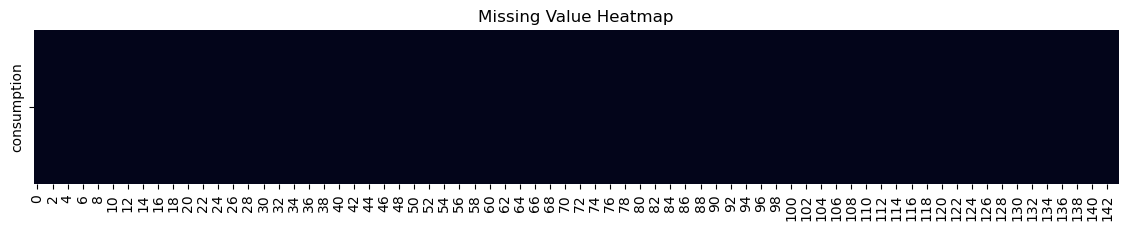

In [34]:
# 5. Missing value heatmap
import seaborn as sns
plt.figure(figsize=(14,2))
sns.heatmap(df['consumption'].isnull().to_frame().T, cbar=False)
plt.title('Missing Value Heatmap')
plt.show()

In [16]:
# 6. Summary statistics
print(df['consumption'].describe())
print('Skewness:', df['consumption'].skew())
print('Kurtosis:', df['consumption'].kurt())

count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: consumption, dtype: float64
Skewness: 0.5831604861560892
Kurtosis: -0.3649418621454963


In [35]:
# STEP 4: Time-Based Train/Test Split
forecast_horizon = 12  # User can change this value
train = df['consumption'][:-forecast_horizon]
test = df['consumption'][-forecast_horizon:]
print(f'Train shape: {train.shape}, Test shape: {test.shape}')

Train shape: (132,), Test shape: (12,)


In [36]:
# Automated model recommendation based on time series analysis
recommendation = []
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
stl = STL(df['consumption'], period=12)
res = stl.fit()
seasonality_strength = res.seasonal.std() / df['consumption'].std()
adf_pvalue = adfuller(df['consumption'].dropna())[1]
kpss_stat, kpss_p, _, _ = kpss(df['consumption'].dropna(), regression='c', nlags='auto')
if seasonality_strength > 0.3:
    recommendation.append('Prophet or SARIMA (strong seasonality detected)')
if adf_pvalue > 0.05 or kpss_p < 0.05:
    recommendation.append('Apply differencing or use models that handle non-stationarity (Prophet, SARIMA)')
if len(df) < 50:
    recommendation.append('Dataset is short: use ARIMA or Exponential Smoothing')
elif len(df) > 200:
    recommendation.append('Dataset is long: LSTM/Deep Learning models are possible')
print('Model Recommendations:')
for rec in recommendation:
    print('-', rec)

Model Recommendations:
- Prophet or SARIMA (strong seasonality detected)
- Apply differencing or use models that handle non-stationarity (Prophet, SARIMA)


C:\Users\HAMZA\AppData\Local\Temp\ipykernel_6424\1710559485.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, _ = kpss(df['consumption'].dropna(), regression='c', nlags='auto')


MAE: 16.31, RMSE: 21.18, MAPE: 3.68%


c:\Users\HAMZA\.conda\envs\cuda_test\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


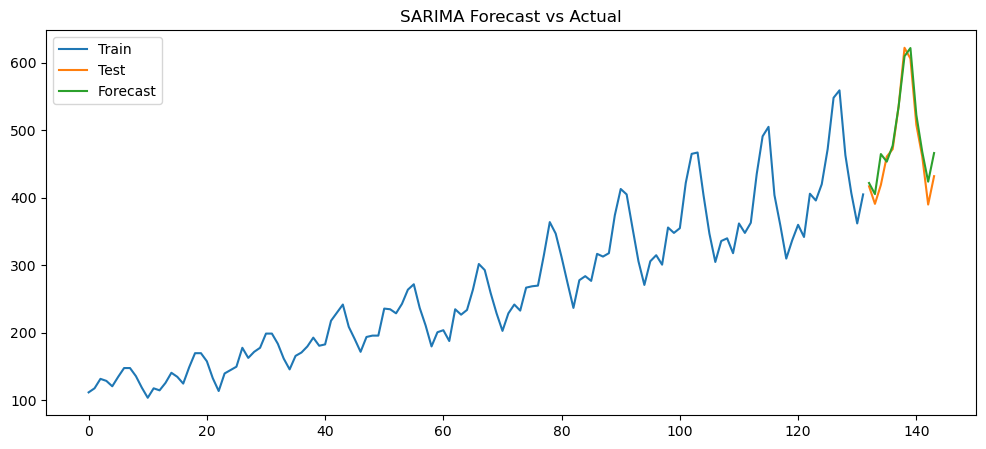

In [37]:
# Train/test split and SARIMA model training/testing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
n_test = 12  # last 12 months for testing
train = df['consumption'][:-n_test]
test = df['consumption'][-n_test:]
# Fit SARIMA (simple seasonal model, can be tuned)
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)
forecast = model_fit.forecast(steps=n_test)
# Evaluation
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100
print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%')
# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.title('SARIMA Forecast vs Actual')
plt.show()

In [ ]:
# STEP 7: Model Selection (Based on Metrics)
# (Extend this cell to compare multiple models and select the best by MAE, RMSE, MAPE, etc.)
# Example placeholder:
# results = {'SARIMA': {'mae': mae, 'rmse': rmse, 'mape': mape}}
# print('Best model:', min(results, key=lambda k: results[k]['rmse']))

In [ ]:
# STEP 8: Model Saving + Reusability
import joblib
# Save model
joblib.dump(model_fit, '../models/sarima_model.joblib')
# Save preprocessing pipeline (example: columns to keep, scaler, etc.)
preprocessing_info = {'columns': df.columns.tolist(), 'index_freq': pd.infer_freq(df.index)}
joblib.dump(preprocessing_info, '../models/preprocessing_info.joblib')
# Save metrics/metadata
metadata = {'mae': mae, 'rmse': rmse, 'mape': mape, 'model': 'SARIMA', 'train_shape': train.shape, 'test_shape': test.shape}
joblib.dump(metadata, '../models/metadata.joblib')
print('Model, preprocessing info, and metadata saved to ../models/')

In [24]:
# STEP 0: Load Data
import seaborn as sns
import pandas as pd
df = sns.load_dataset('flights')
df['datetime'] = pd.to_datetime(df[['year', 'month']].astype(str).agg('-'.join, axis=1))
df = df.rename(columns={'passengers': 'consumption'})
df = df[['datetime', 'consumption']]
df.head()

C:\Users\HAMZA\AppData\Local\Temp\ipykernel_6424\2762223645.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df[['year', 'month']].astype(str).agg('-'.join, axis=1))


,datetime,consumption
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
